This notebook contains a simple UI to enable users to test toy models or quickly and interactively perform single calculations of a transformer thermal model using thier own operating conditions as input.

This file is part of IEEE C57.91 2024 project which is released under BSD-3-Clause.
See file LICENSE.md or go to https://opensource.ieee.org/inslife/ieee-c57.91-2024/ for full license details.

# Thermal Model for Power Transformers

Executes code which calculates the temperatures inside a power transformer using its thermal properties derived from factory acceptance testing, load, and ambient temperature using a model developed by L.W. Pierce.  The model is also described in Annex G of IEEE C57.91-2015.

Modifications to use differential equations and code developed by Oleg Roizmann <sup>1</sup> and Zack Draper <sup>2</sup>.

<sup>1</sup> oleg.roizman@intellpower.com

<sup>2</sup> zhdraper@deltaxresearch.com

### References

Pierce, L. W., An Investigation of the Thermal Performance of an Oil Filled Transformer Winding, IEEE
Transactions on Power Delivery, vol. 7, no. 3, pp. 1347–1358, July 1992.

Pierce, L. W., Predicting Liquid Filled Transformer Loading Capability, IEEE Transactions on Industry
Applications, vol. 30, no. 1, pp. 170–178, Jan./Feb. 1994.


In [9]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import json
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)

from scipy.integrate import odeint, solve_ivp
from scipy.interpolate import interp1d

from datetime import datetime

import time as pyt

import ipywidgets as widgets
from ipywidgets import interact, interact_manual, interactive
from ipywidgets import IntSlider, FloatSlider
from traitlets import dlink
from IPython.display import display,clear_output

import transformer_thermal_models
from transformer_thermal_models import Transformer, LoadConditions

from io import BytesIO

import copy

file_picker = None

import pkg_resources
import types
def get_imports():
    for name, val in globals().items():
        if isinstance(val, types.ModuleType):
            name = val.__name__.split(".")[0]

        elif isinstance(val, type):
            name = val.__module__.split(".")[0]

        poorly_named_packages = {
            "PIL": "Pillow",
            "sklearn": "scikit-learn"
        }
        if name in poorly_named_packages.keys():
            name = poorly_named_packages[name]

        yield name
imports = list(set(get_imports()))

if False:
    requirements = []
    for m in pkg_resources.working_set:
        if m.project_name in imports and m.project_name!="pip":
            requirements.append((m.project_name, m.version))

    with open('requirements.txt','w') as f:
        for r in requirements:
            f.write("{}>={}".format(*r)+'\n')
        f.write("voila>=0.2.10")

In [10]:
import base64
from IPython.display import HTML

def create_download_link( csv, title = "Download CSV file", filename = "thermal_model.csv"):
    #csv = df.to_csv(index=False)
    b64 = base64.b64encode(csv.encode())
    payload = b64.decode()
    html = '<a download="{filename}" href="data:text/csv;base64,{payload}" target="_blank">{title}</a>'
    html = html.format(payload=payload,title=title,filename=filename)
    return HTML(html)

## Modifications to IEEE-C57.91-2024-MAIN
by Jessica Kerby, jessica.kerby@pnnl.gov 
### Investigating the thermal impacts of inadvertent export at the seconds timescale

Note from IEEE Guide for Loading Mineral Oil Immersed Transformers:
Because many factors influence the cumulative effect of temperature over time in causing
deterioration of transformer insulation, it is not possible to predict with any great degree of accuracy the useful life of the insulation in a transformer, even under constant or closely controlled conditions, much less under widely varying service conditions. Wherever the word *“life”* is used in this guide, it *means calculated insulation life, not actual
transformer life*.

#### New files:
`Thermal_Modeling_UI_Example_Voila_EDIT.ipynb` 

#### Instructions for additional modifications:
After any changes to the model, reinitialize with `python -m pip install .` to implement.    

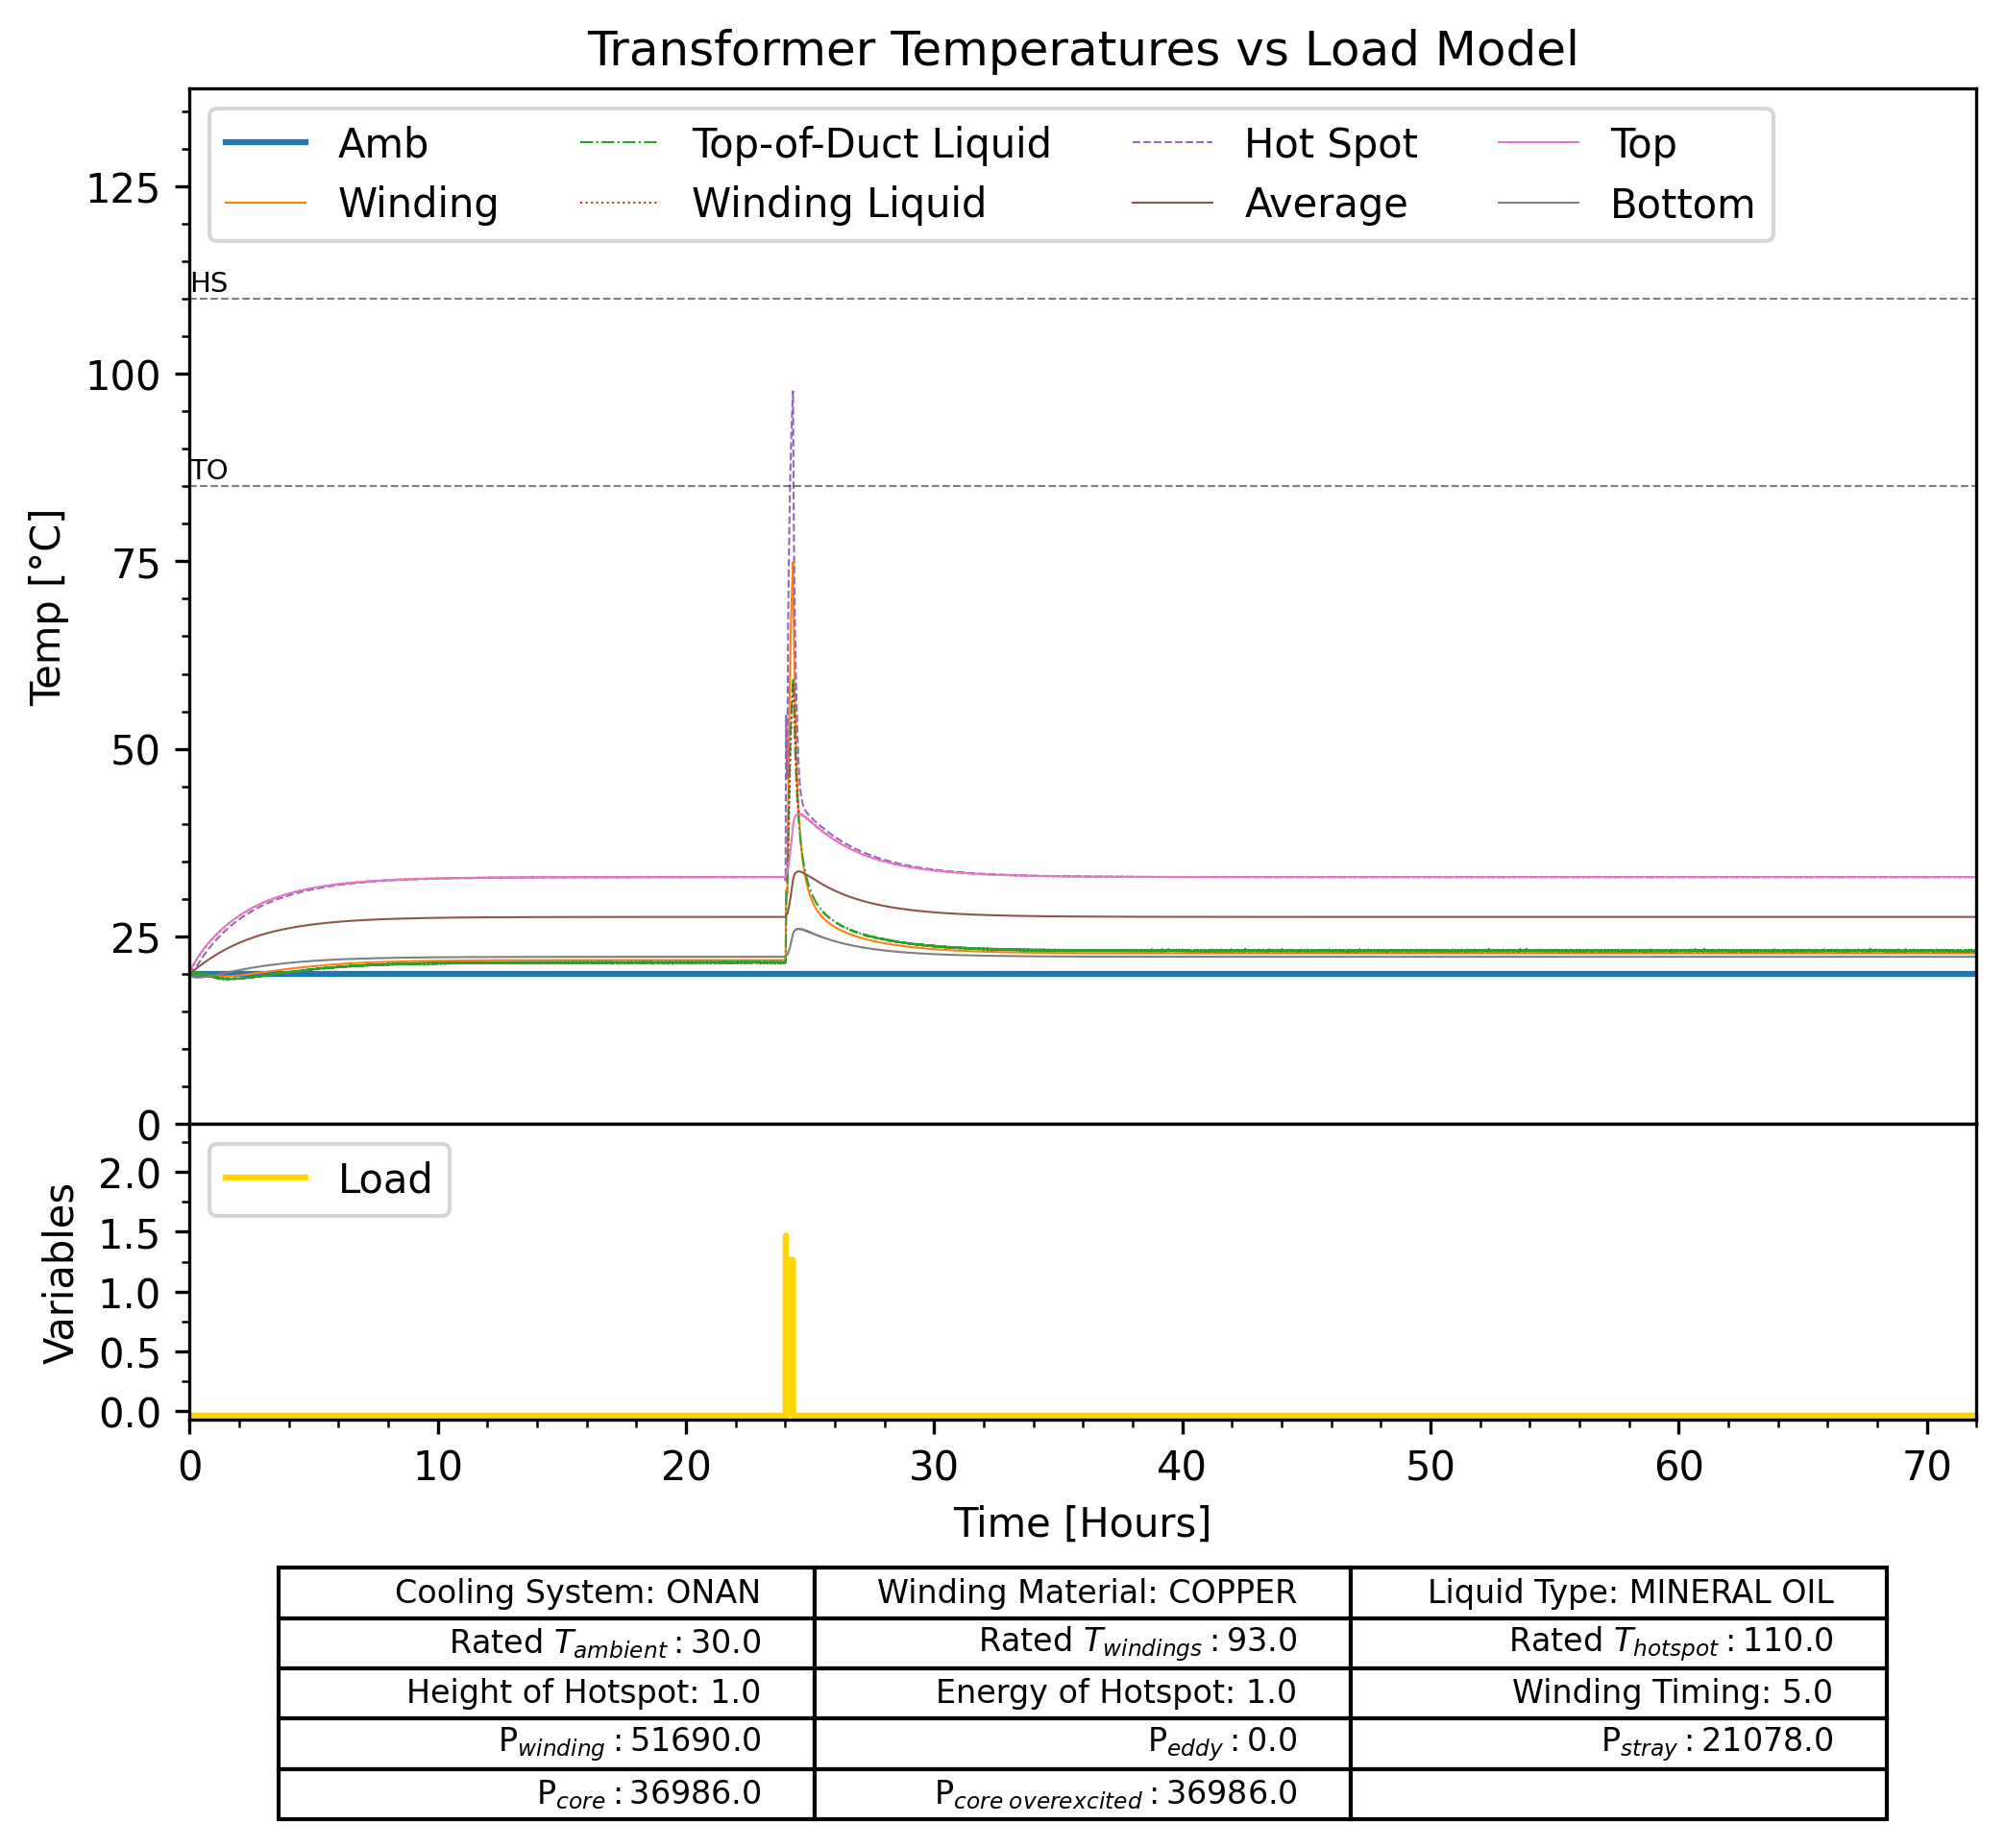

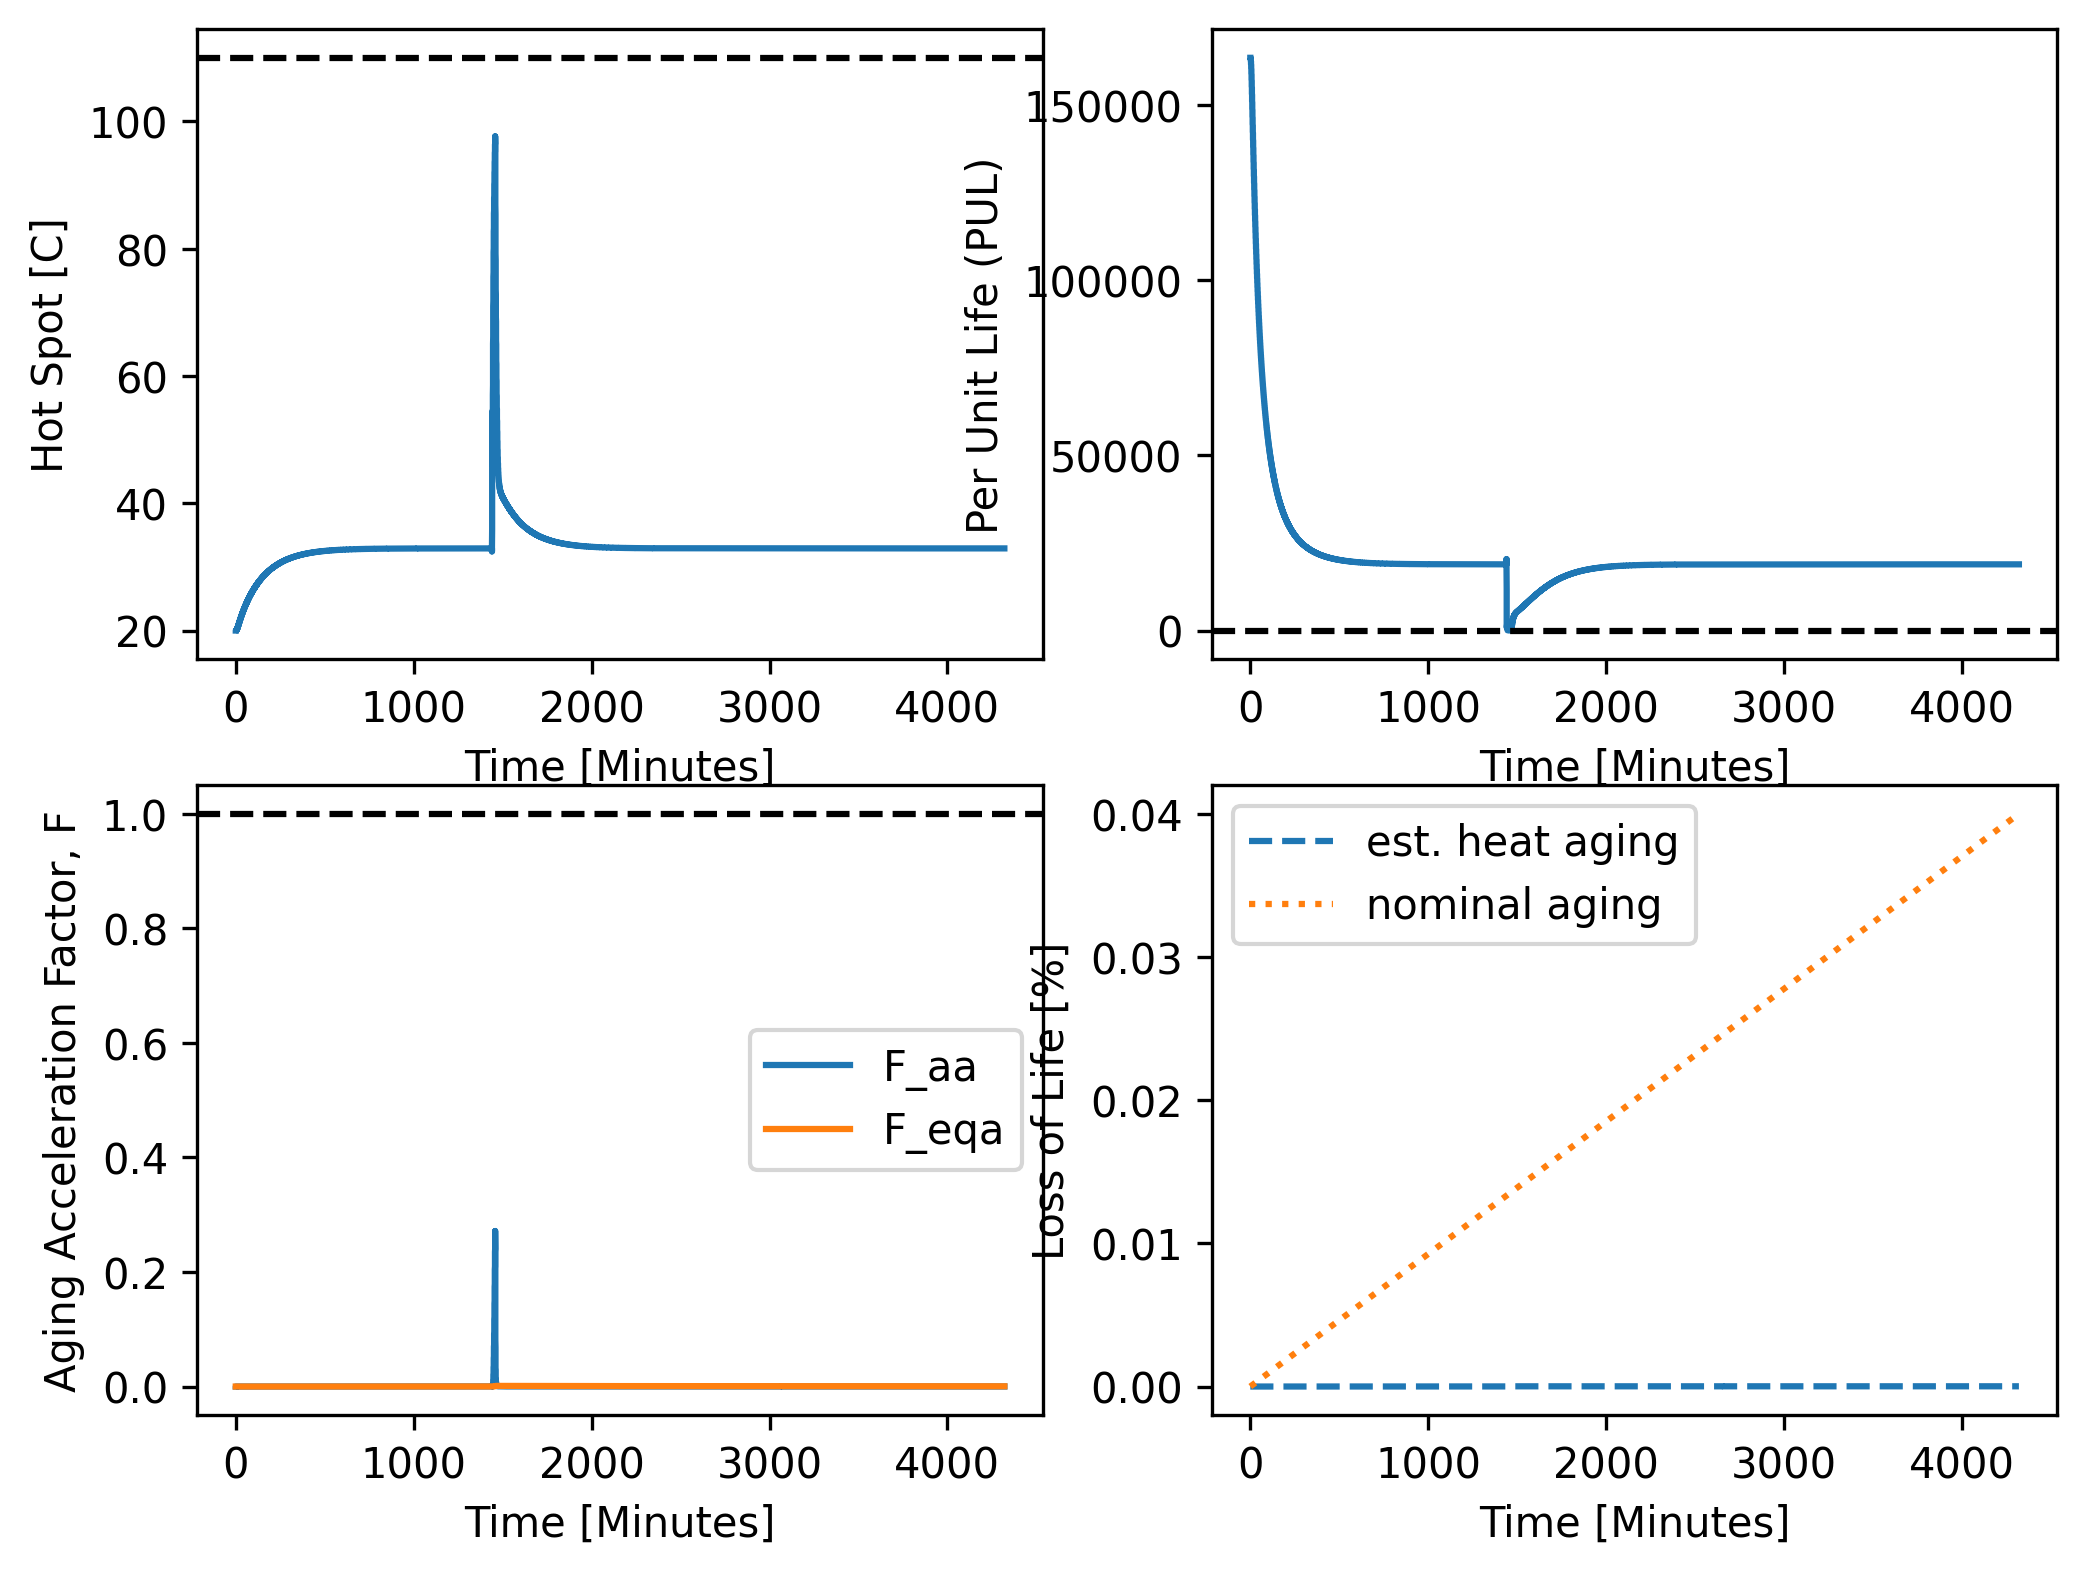

In [11]:
out = widgets.Output(layout={'border': '1px solid black'})

file_picker = widgets.FileUpload(accept='*.csv',multiple=False)
file_name = widgets.Text()
button_engage = widgets.Button(description='Engage',value=None)

layout = widgets.Layout(width='500px')

mva_rated_box = widgets.FloatText(
    value = 52.0,
    description="Rated MVA of Transformer [MVA]: ",
    flex_flow='column',
    align_items='stretch', 
    style= {'description_width': 'initial'},
    layout=layout,
)

mva_loss_box = widgets.FloatText(
    value = 28.0,
    description="MVA at which losses were measured [MVA]: ",
    flex_flow='column',
    align_items='stretch', 
    style= {'description_width': 'initial'},
    layout=layout,
)

T_loss_box = widgets.FloatText(
    value = 75.0,
    description="Temperature at which losses were measured [C]: ",
    flex_flow='column',
    align_items='stretch', 
    style= {'description_width': 'initial'},
    layout=layout,
)

P_wr_box = widgets.FloatText(
    value = 51690,
    description=r"Winding I**2*R loss at rated load [W]: ",
    flex_flow='column',
    align_items='stretch', 
    style= {'description_width': 'initial'},
    layout=layout,
)

P_er_box = widgets.FloatText(
    value = 0,
    description=r"Eddy loss of windings at rated load [W]: ",
    flex_flow='column',
    align_items='stretch', 
    style= {'description_width': 'initial'},
    layout=layout,
)

P_sr_box = widgets.FloatText(
    value = 21078,
    description=r"Power in stray losses [W]: ",
    flex_flow='column',
    align_items='stretch', 
    style= {'description_width': 'initial'},
    layout=layout,
)

P_cr_box = widgets.FloatText(
    value = 36986,
    description=r"Power in core losses [W]: ",
    flex_flow='column',
    align_items='stretch', 
    style= {'description_width': 'initial'},
    layout=layout,
)
    

P_coe_box = widgets.FloatText(
    value = 36986,
    description="Power in core losses when overexcited (load > 1) [W]: ",
    flex_flow='column',
    align_items='stretch', 
    style= {'description_width': 'initial'},
    layout=layout,
)

E_hs_box = widgets.FloatText(
    value = 1.0,
    description=r"Energy of hotspot [1]: *",
    flex_flow='column',
    align_items='stretch', 
    style= {'description_width': 'initial'},
    layout=layout,
)

M_cc_box = widgets.FloatText(
    value = 75600,
    description="Weight of core and coils [lb]: ",
    flex_flow='column',
    align_items='stretch', 
    style= {'description_width': 'initial'},
    layout=layout,
)

M_tank_box = widgets.FloatText(
    value = 31400,
    description="Weight of tank and fittings [lb]: ",
    flex_flow='column',
    align_items='stretch', 
    style= {'description_width': 'initial'},
    layout=layout,
)

liquid_volume_box = widgets.FloatText(
    value = 4910,
    description="Liquid volume [gal]: ",
    flex_flow='column',
    align_items='stretch', 
    style= {'description_width': 'initial'},
    layout=layout,
)

T_ambr_box = widgets.FloatText(
    value = 30.0,
    description="Temperature of ambient at rated load [C]: ",
    flex_flow='column',
    align_items='stretch', 
    style= {'description_width': 'initial'},
    layout=layout,
)

T_wg_box = widgets.FloatText(
    value = 65.0,
    description="Gaurantee rated rise temperature [C]: ",
    flex_flow='column',
    align_items='stretch', 
    style= {'description_width': 'initial'},
    layout=layout,
)

T_wr_box = widgets.FloatText(
    value = 63.0,
    description=r"Winding temperature rise at rated load [C]: *",
    flex_flow='column',
    align_items='stretch', 
    style= {'description_width': 'initial'},
    layout=layout,
)

T_hsr_box = widgets.FloatText(
    value = 80.0,
    description=r"Hotspot temperature rise at rated load [C]: ",
    flex_flow='column',
    align_items='stretch', 
    style= {'description_width': 'initial'},
    layout=layout,
)

T_tor_box = widgets.FloatText(
    value = 55.0,
    description="Top Liquid temperature rise at rated load [C]: ",
    flex_flow='column',
    align_items='stretch', 
    style= {'description_width': 'initial'},
    layout=layout,
)

T_bor_box = widgets.FloatText(
    value = 25.0,
    description=r"Bottom Liquid temperature rise at rated load [C]: *",
    flex_flow='column',
    align_items='stretch', 
    style= {'description_width': 'initial'},
    layout=layout,
)

T_k_box = widgets.FloatText(
    value = 234.5,
    description="Temperature correction for lossess of winding [C]: ",
    flex_flow='column',
    align_items='stretch', 
    style= {'description_width': 'initial'},
    layout=layout,
)

H_hs_box = widgets.FloatText(
    value = 1.0,
    description=r"Height of hotspot [1]: *",
    flex_flow='column',
    align_items='stretch', 
    style= {'description_width': 'initial'},
    layout=layout,
)

tau_w_box = widgets.FloatText(
   value = 5,
   description="Winding time constant [min]: ",
   flex_flow='column',
   align_items='stretch', 
   style= {'description_width': 'initial'},
   layout=layout,
)


cooling_system_box = widgets.Dropdown(
    options=['ONAN', 'ODAF', 'OFAF', 'ONAF'],
    value='ONAN',
    description='Cooling System: ',
    disabled=False,
    flex_flow='column',
    align_items='stretch', 
    style= {'description_width': 'initial'},
)

winding_material_box = widgets.Dropdown(
    options=['Copper', 'Aluminium'],
    value='Copper',
    description=r'Winding Material: *',
    disabled=False,
    flex_flow='column',
    align_items='stretch', 
    style= {'description_width': 'initial'},
)

liquid_type_box = widgets.Dropdown(
    options=['Mineral Oil'],
    value='Mineral Oil',
    description=r'Liquid Type: *',
    disabled=False,
    flex_flow='column',
    align_items='stretch', 
    style= {'description_width': 'initial'},
)

method_selection = widgets.Dropdown(
    options=[
        ('Main Clause 7 (RK45)', 'main_clause_7_diff'),
        ('Alternative Clause 7 (RK45)', 'alt_clause_7_diff'),
        ('Old Clause 7 (Analytical)', 'old_clause_7_analytical')
    ],
    value='main_clause_7_diff',
    description='Method: ',
)

def sine_ambient(t,A,B,C):
    return A*np.sin(np.pi/12*(t-B))+C

def sine_ambient_widget(A=6,B=15,C=10):
    t=np.linspace(0,24*60,24*3600)
    B-=6
    
    values = sine_ambient(t,A,B,C)
    
    fig = plt.plot()
    plt.plot(t,values)
    plt.xlabel('Hours')
    plt.ylabel('Amb. Temp [C]')
    plt.ylim([-30,45])
    plt.xlim([0,24])
    plt.show()
    
    return t,values

ambient_picker = widgets.interactive(sine_ambient_widget,
                                         A=IntSlider(0, 0, 20, 1, description='Amplitude'),
                                         B=IntSlider(15, 12, 18, 1, description='Time of Peak'),
                                         C=IntSlider(20, -30, 45, 1, description='Average'),
                                        )


def load_simulator_widget(t_start=0.5, t_duration=1, t_inter=1, t_duration2=1, t_inter2=1, t_duration3=1, in_load=0.5, load_peak=1.5, load_peak2=2, load_peak3=2):

    Time = f"{0},{t_start},{t_start + t_duration},{t_start + t_duration + t_inter}, {t_start + t_duration + t_inter+ t_duration2}, {t_start + t_duration + t_inter+ t_duration2 + t_inter2}, {t_start + t_duration + t_inter+ t_duration2 + t_inter2 + t_duration3}"
    Load = f"{in_load},{load_peak},{in_load},{load_peak2}, {in_load}, {load_peak3}, {in_load}"  

    time = [float(x) for x in Time.split(',') if x]
    load = [float(x) for x in Load.split(',') if x]
    
    min_len = min([len(time),len(load)])

    time = time[0:min_len]
    load = load[0:min_len]

    profile = interp1d(time, load, kind='previous', fill_value='extrapolate')

    t = np.linspace(0,24*60,24*3600)
    
        
    fig = plt.plot()
    plt.plot(t,profile(t))
    plt.plot(time,load,'o')
    plt.xlim(0,60)
    #xticks = np.arange(0,60,step=1)
    plt.ylim(0,2)
    plt.ylabel('PLU')
    plt.xlabel('Time [seconds]')
    plt.show()

    return t,profile(t)

load_simulator_picker = widgets.interactive(load_simulator_widget,
                                            in_load=FloatSlider(value=0,min=0,max=2,step=0.1, description='Initial Loading [plu]', style={'description_width': 'initial'},layout={'width': '30%'}),
                                            load_peak=FloatSlider(value=1.5,min=0.1,max=2,step=0.1, description='Load Peak [plu]', style={'description_width': 'initial'},layout={'width': '30%'}),
                                            load_peak2=FloatSlider(value=0,min=0.0,max=2,step=0.1, description='2nd Load Peak [plu]', style={'description_width': 'initial'},layout={'width': '30%'}),
                                            load_peak3=FloatSlider(value=0,min=0.0,max=2,step=0.1, description='3rd Load Peak [plu]', style={'description_width': 'initial'},layout={'width': '30%'}),
                                            t_start=FloatSlider(value=0,min=1,max=60,step=1, description='Event Start Time [s]', style={'description_width': 'initial'},layout={'width': '30%'}),
                                            t_duration=FloatSlider(value=1,min=1,max=20,step=1, description='Event Duration [s]', style={'description_width': 'initial'},layout={'width': '30%'}),
                                            t_inter=FloatSlider(value=1,min=1,max=20,step=1, description='Time Between Events (1 & 2) [s]', style={'description_width': 'initial'},layout={'width': '30%'}),
                                            t_duration2=FloatSlider(value=1,min=1,max=20,step=1, description='2nd Event Duration [s]', style={'description_width': 'initial'},layout={'width': '30%'}),
                                            t_inter2=FloatSlider(value=1,min=1,max=20,step=1, description='Time Between Events (2 & 3) [s]', style={'description_width': 'initial'},layout={'width': '30%'}),
                                            t_duration3=FloatSlider(value=1,min=1,max=20,step=1, description='3rd Event Duration [s]', style={'description_width': 'initial'},layout={'width': '30%'}),
                                            )



#def plot_load_picker(Time='0,2,14,24',Load='0.5,1.5,1.0,0.5'): 
#    try:
#        time = [float(x) for x in Time.split(',') if x]
#        load = [float(x) for x in Load.split(',') if x]
#        min_len = min([len(time),len(load)]
#        time = time[0:min_len]
#        load = load[0:min_len]
#        profile = interp1d(time, load, kind='previous', fill_value='extrapolate')
#        t = np.linspace(0,24,60*24)
#        fig = plt.plot()
#        plt.plot(t,profile(t))
#        plt.plot(time,load,'o')
#        plt.xlim(0,24)
#        plt.ylim(0,2)
#        plt.ylabel('PLU')
#        plt.xlabel('Time')
#        plt.show()
#    except:
#        print('Invalid input, cannot plot')
#        pass
#    return t,profile(t)
#load_picker = interactive(plot_load_picker)

vbox = widgets.VBox([
    widgets.HTML(value='<b>Method Selection</b>'),
    widgets.HBox([method_selection]),
    widgets.HTML(value='<b>Time Dependent Variables</b>'),
    widgets.Label(value=r'You have two options here: '),
    widgets.Label(value=r'1) Upload a CSV file containing specific time dependent data.'),
    widgets.Label(value=r'2) Use the model parameter selections below to run a test model.'),
    widgets.Label(value=r'If a file is uploaded, it will run the file and not the model parameters.'),
    widgets.HTML(value='<u>Upload File:</u>'),
    widgets.Label(value=r'Upload a file containing the required or optional input time-dependent data:'),
    widgets.HBox([file_picker, file_name]),
    widgets.HTML(value='<u> Model Configuration:</u>'),
    #widgets.Label(value=r'If you do not upload a file, you can manually select the required input time-dependent data [hours]:'),
    widgets.Label(value=r'Original model designed for hourly timescale. At the minute timescale, default assumes constant ambient temp. Adjust the average slider to set the temperature.'),
    ambient_picker,
    #widgets.Label(value=r'Manually type in an ordered list of time [hours] and load [plu] varibles, seperated by commas, and the plot will update the load for input:'),
    widgets.Label(value=r'Adjust the start time, duration, and time between peak load events. Then adjust the the initial load and size of each peak. By default there is one load event. Up to three can be specified.'),
    #load_picker,
    load_simulator_picker,
    widgets.HTML(value='<b>Set Transformer Thermal Properties</b>'),
    mva_rated_box,
    mva_loss_box,
    T_loss_box,
    P_wr_box,
    P_er_box,
    P_sr_box,
    P_cr_box,
    P_coe_box,
    E_hs_box,
    M_cc_box,
    M_tank_box,
    liquid_volume_box,
    T_ambr_box,
    T_wg_box,
    T_wr_box,
    T_hsr_box,
    T_tor_box,
    T_bor_box,
    T_k_box,
    H_hs_box,
    tau_w_box,
    cooling_system_box,
    winding_material_box,
    liquid_type_box,
    widgets.HTML(value='(<b>*</b>) Additional variables required for full model (Main C7).'),
    widgets.HTML(value='<b>Execute Model</b>'),
    widgets.HBox([button_engage]),
])

# get filename from FileUpload dict
def get_name(file_upload):
    if len(file_upload) == 0:
        return ''
    return file_upload[0].get('name','')

def change_input(change):
    global vbox, file_picker, file_name

dlink((file_picker, 'value'), (file_name, 'value'), get_name)
file_picker.observe(change_input, 'value')

def execute_model(v):
    out = widgets.Output() 
    out.capture(clear_output=True)

    with out:
        clear_output(wait=True)
        
        print("Processing... ")
        
        method = method_selection.value
        
        print("Using method: ",method)
        
        xfr = Transformer()
        
        xfr.MVA_rated = mva_rated_box.value # Rated MVA
        xfr.MVA_loss = mva_loss_box.value # MVA which losses were measured
        xfr.T_loss = T_loss_box.value # temperature which losses were measured 
        xfr.P_wr = P_wr_box.value # winding I**2*R loss at rated load [W]
        xfr.P_er = P_er_box.value # eddy loss of windings at rated load [W]
        xfr.P_sr = P_sr_box.value # power in stray losses [W]
        xfr.P_cr = P_cr_box.value # power in core losses [W]
        xfr.P_coe = P_coe_box.value # power in core losses when overexcited (load > 1) [W]
        xfr.E_hs = E_hs_box.value # [1]
        xfr.M_cc = M_cc_box.value # weight (mass proxy) of core and coils [lb]
        xfr.M_tank = M_tank_box.value # weight (mass proxy) of tank and fittings [lb]
        xfr.liquid_volume = liquid_volume_box.value # liquid volume [gal]
        xfr.T_ambr = T_ambr_box.value # temperature rise of ambient at rated load [C]
        xfr.T_wg = T_wg_box.value # gauranted rated temperature rise [C]
        xfr.T_wr = T_wr_box.value # temperature rise of windings [C]
        xfr.T_hsr = T_hsr_box.value # temperature rise of hotspot at rated load [C]
        xfr.T_tor = T_tor_box.value # temperature rise of top liquid at rated load [C]
        xfr.T_bor = T_bor_box.value # temperature rise of bottom liquid at rated load [C]
        xfr.T_k = T_k_box.value # temperature correction for lossess of winding [C]
        xfr.H_hs = H_hs_box.value # relative height of hotspot in windings [0-1]
        xfr.tau_w = tau_w_box.value # winding time constant [min]
        xfr.cooling_system = cooling_system_box.value # type of cooling system
        xfr.winding_material = winding_material_box.value
        xfr.liquid_type = liquid_type_box.value

        if len(file_picker.value) > 0:
            print('Using user uploaded input data...')
            
            content = file_picker.value[0].get('content')
            conditions = LoadConditions().import_data(BytesIO(content))

        else:
            print('Using manual UI input...')
            
            conditions = LoadConditions()

            time = ambient_picker.result[0]
            T_ambient_o = ambient_picker.result[1]
            load = load_simulator_picker.result[1]

            preload = np.zeros(len(time)) + load[0]
            postload = np.zeros(len(time)) + load[-1]

            load = np.append(preload,load)
            load = np.append(load,postload)

            T_ambient = np.append(T_ambient_o,T_ambient_o)
            T_ambient = np.append(T_ambient,T_ambient_o)

            time = np.linspace(0,3*24*60,3*24*3600)                 
                    
            conditions.T_ambient = T_ambient
            conditions.load = load
            conditions.time = time
            conditions.update_profiles()
    
        transformer_thermal_models.solve_temperatures(xfr,conditions,method)
        
        transformer_thermal_models.solve_estimated_loss_of_life(xfr,conditions)
                
        plt.tight_layout()
        plt.show()

        output_csv = transformer_thermal_models.export_data(xfr,conditions)
        
        dl_link = create_download_link(output_csv)
        display(dl_link)
            
        transformer_thermal_models.plotting.plot_results(xfr,conditions)
        display(plt.gcf())
        
        json_string = xfr.to_json()
        with open('transformer_thermal_nameplate.json', 'w') as outfile:
            json.dump(json_string, outfile)

        time_select = np.linspace(time[0], time[-1], 25920, dtype=int)
        pul,V,F_eqa,loss_of_life = transformer_thermal_models.estimate_loss_of_life(xfr.solution['Hot Spot [C]'].values,time_select)
        nominal_insulation_life = 180000
        print("Nominal aging at rated hot-spot temperature equal to " + str(np.round(loss_of_life[-1],5)))

        axs = plt.subplots(2,2,figsize=(8,6),dpi=300)
        axs[1]

        axs[1][0][0].plot(time_select,xfr.solution['Hot Spot [C]'].values)
        axs[1][0][0].axhline(110,color='k',ls='--')
        axs[1][0][0].set_ylabel('Hot Spot [C]')
        axs[1][0][0].set_xlabel('Time [Minutes]') 

        axs[1][0][1].plot(time_select,pul)
        axs[1][0][1].axhline(1,color='k',ls='--')
        axs[1][0][1].set_ylabel('Per Unit Life (PUL)')
        axs[1][0][1].set_xlabel('Time [Minutes]') 

        axs[1][1][0].plot(time_select,V,label='F_aa')
        axs[1][1][0].plot(time_select,F_eqa,label='F_eqa')
        axs[1][1][0].axhline(1,color='k',ls='--')
        axs[1][1][0].set_ylabel(r'Aging Acceleration Factor, F')
        axs[1][1][0].set_xlabel('Time [Minutes]') 
        axs[1][1][0].legend()

        axs[1][1][1].plot(time_select,loss_of_life,'--',label='est. heat aging')
        axs[1][1][1].plot(time_select,time_select/60/nominal_insulation_life*100,':',label='nominal aging')
        axs[1][1][1].set_ylabel(r'Loss of Life [%]')
        axs[1][1][1].set_xlabel('Time [Minutes]') 
        axs[1][1][1].legend()
        display(plt.gcf())
            
    vbox.children = (*vbox.children, out)
    
    return out

button_engage.on_click(execute_model)




In [12]:
vbox